In [ ]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy.fft import fft, fftfreq
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense
from keras.utils import set_random_seed
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from itertools import product
import warnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load datasets
jj_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/jj.csv')
amzn_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AMZN.csv')
amzn_data['Date']=pd.to_datetime(amzn_data['Date'])
amzn_data.set_index('Date',inplace=True)

**Exploratory Data Analysis**

In [ ]:
jj_data.head(5)

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [ ]:
amzn_data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-20,72.324501,74.438499,72.324501,73.417503,73.417503,129984000
2018-02-21,74.250000,75.174500,73.945999,74.146004,74.146004,126088000
2018-02-22,74.767998,75.126999,73.788002,74.266998,74.266998,97162000
2018-02-23,74.766998,75.000000,74.324997,75.000000,75.000000,88362000
2018-02-26,75.459999,76.141998,75.349998,76.097504,76.097504,99100000


**Plot J&J  and Amazon data**

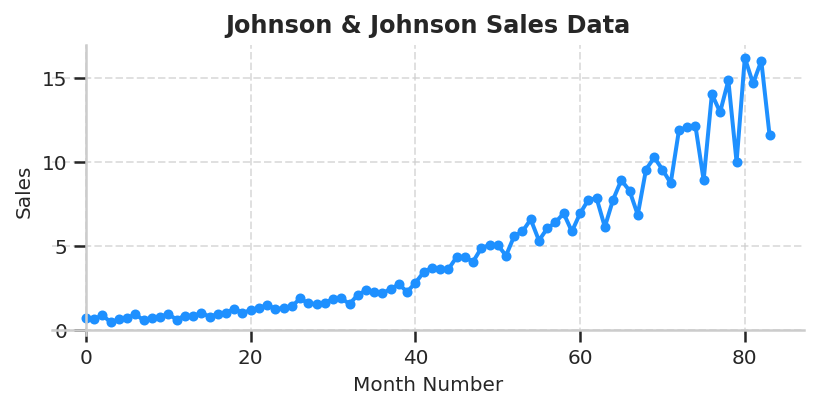

In [ ]:
#Plotting the J&J sales data
sns.set(style="whitegrid")
x_values = range(len(jj_data['data']))
fig, ax = plt.subplots(figsize=(6,3), dpi=144)
ax.plot(x_values, jj_data['data'], color='dodgerblue', linewidth=2, marker='o', markersize=4)

ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.grid(True, linestyle='--', alpha=0.6)
ax.set_title('Johnson & Johnson Sales Data', fontsize=12, fontweight='bold')
ax.set_ylabel('Sales', fontsize=10)
ax.set_xlabel('Month Number', fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

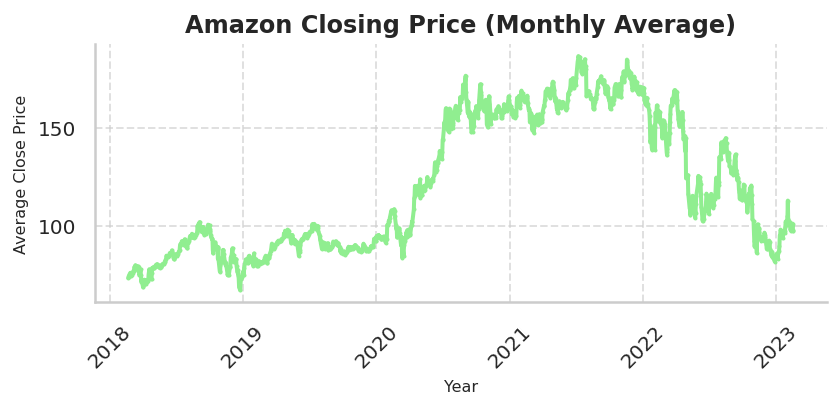

In [ ]:
# Plotting Amazon data
sns.set(style="whitegrid")
x_values = amzn_data.index
fig, ax = plt.subplots(figsize=(6,3), dpi=144)

ax.plot(x_values, amzn_data['Close'], color='lightgreen', linewidth=2, marker='o', markersize=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Amazon Closing Price (Monthly Average)', fontsize=12, fontweight='bold')
ax.set_xlabel('Year', fontsize=8)
ax.set_ylabel('Average Close Price', fontsize=8)

ax.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

**ACF and PACF Plots**

###  Autocorrelation Function (ACF)

- The Autocorrelation Function (ACF) measures the correlation between the time series and its lagged versions.
- It captures both direct and indirect relationships between current and past observations.


### Partial Autocorrelation Function (PACF)

- The Partial Autocorrelation Function (PACF) measures the correlation between the time series and its lagged values after removing the influence of earlier lags.


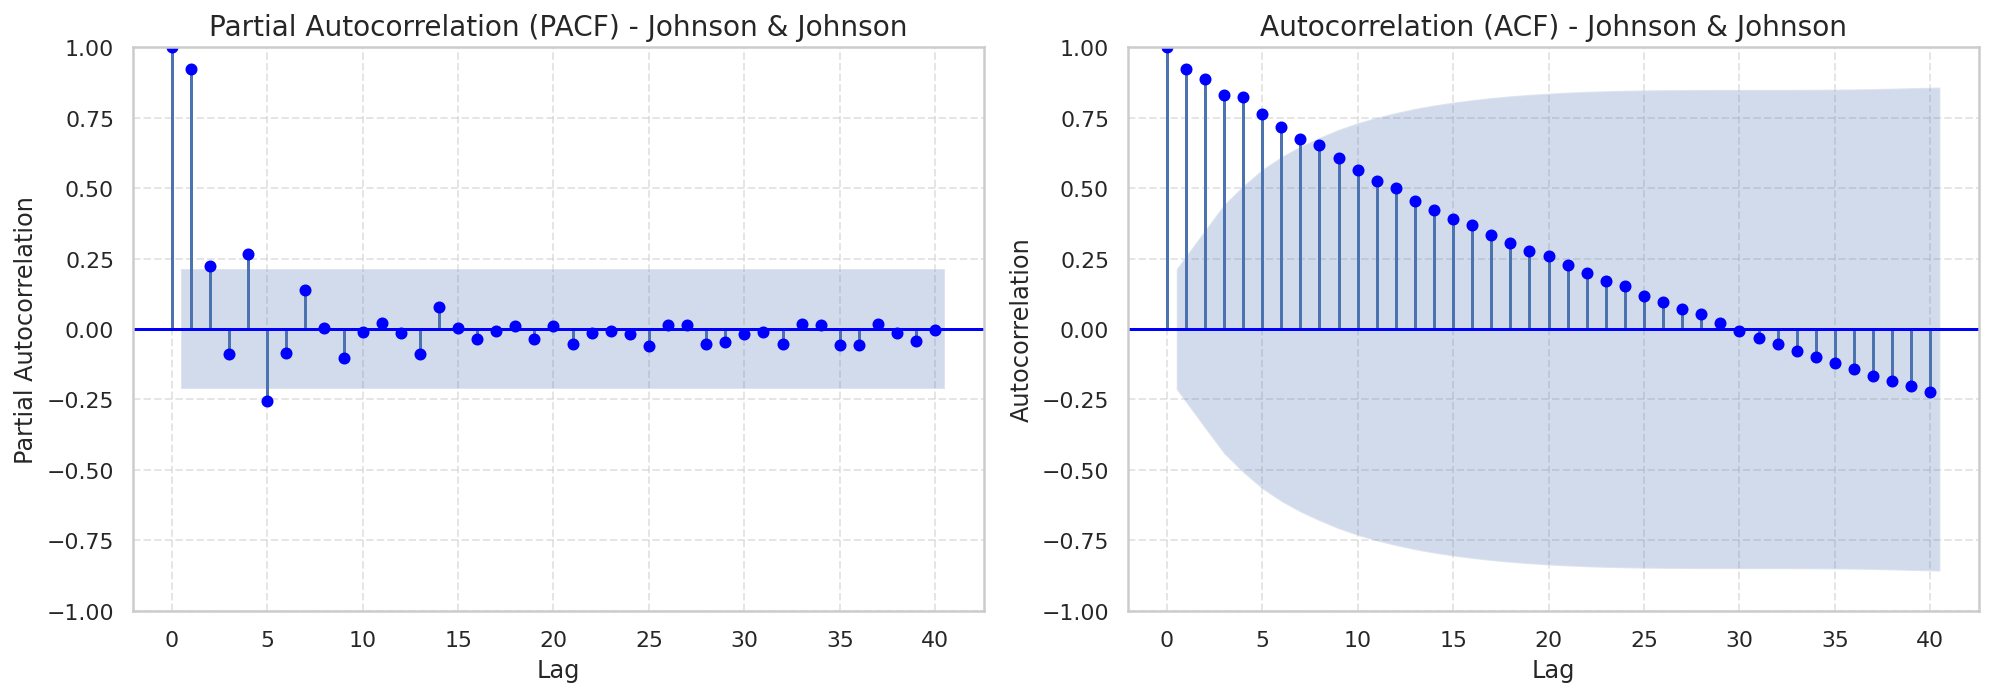

In [ ]:
# ACF and PACF for Johnson and Johnson
sns.set(style='whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(14, 5), dpi=144)

# PACF Plot
plot_pacf(jj_data['data'], ax=ax[0], lags=40, method='ywm', color='blue')
ax[0].set_title('Partial Autocorrelation (PACF) - Johnson & Johnson', fontsize=14)
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Partial Autocorrelation')
ax[0].grid(True, linestyle='--', alpha=0.5)

# ACF Plot
plot_acf(jj_data['data'], ax=ax[1], lags=40, color='blue')
ax[1].set_title('Autocorrelation (ACF) - Johnson & Johnson', fontsize=14)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Autocorrelation')
ax[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

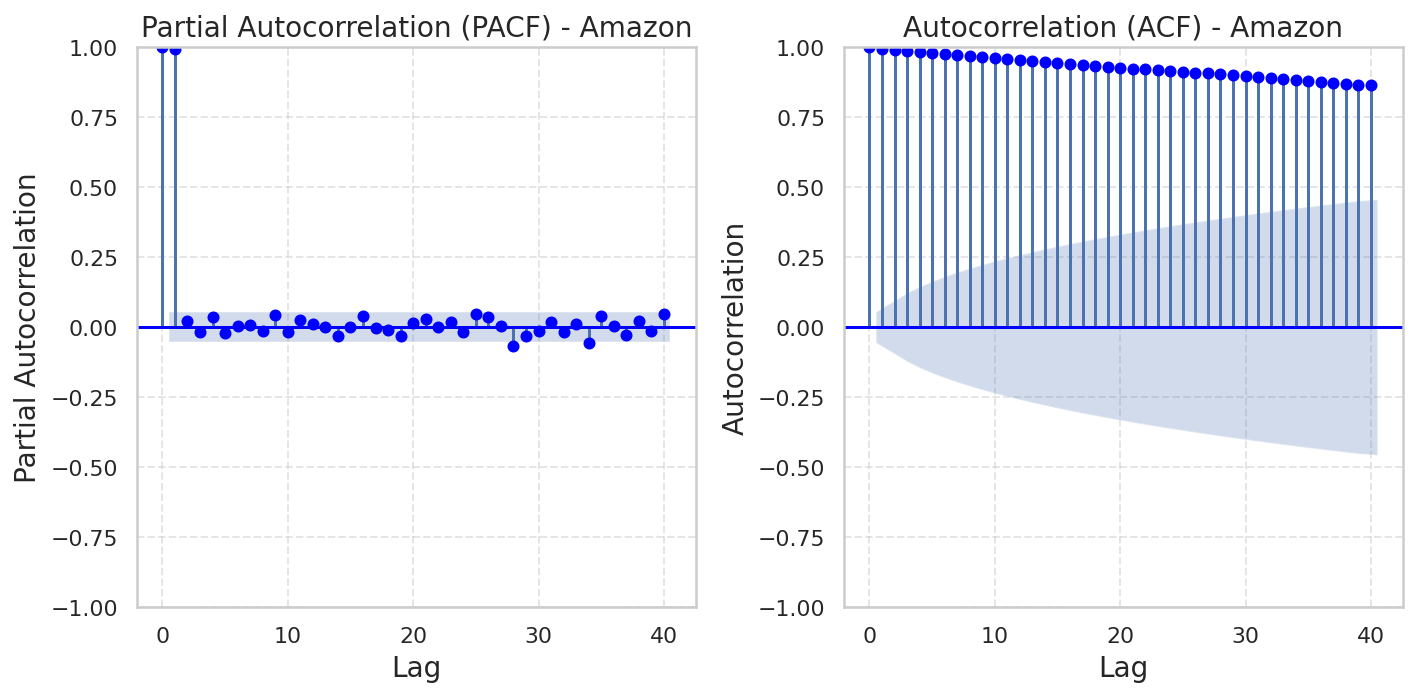

In [ ]:
#ACF and PACF for Amazon
sns.set(style='whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=144)
plot_pacf(amzn_data['Close'], ax=ax[0], lags=40, method='ywm', color='blue')

ax[0].set_title('Partial Autocorrelation (PACF) - Amazon', fontsize=14)
ax[0].set_xlabel('Lag', fontsize=14)
ax[0].set_ylabel('Partial Autocorrelation', fontsize=14)
ax[0].grid(True, linestyle='--', alpha=0.5)

plot_acf(amzn_data['Close'], ax=ax[1], lags=40, color='blue')
ax[1].set_title('Autocorrelation (ACF) - Amazon', fontsize=14)
ax[1].set_xlabel('Lag', fontsize=14)
ax[1].set_ylabel('Autocorrelation', fontsize=14)
ax[1].grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**ADF Test**

The Augmented Dickey-Fuller (ADF) test looks for a unit root,
which denotes nonstationary brought on by trends
or other systematic changes, in order to see
whether a time series is stationary or not.

In [ ]:
# ADF Test for J&J data
ad_fuller_result = adfuller(jj_data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.7420165734574744
p-value: 1.0


In [ ]:
# ADF Test for Amazon data
ad_fuller_result = adfuller(amzn_data['Close'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.6578089913331728
p-value: 0.45297105465166737


In [ ]:
# take the log()
jj_data['data_log'] = np.log(jj_data['data'])
# take the first difference
jj_data['data_tr_1'] = jj_data['data_log'].diff()
jj_data.head(10)

,date,data,data_log,data_tr_1
0,1960-01-01,0.71,-0.342490,NaN
1,1960-04-01,0.63,-0.462035,-0.119545
2,1960-07-02,0.85,-0.162519,0.299517
3,1960-10-01,0.44,-0.820981,-0.658462
4,1961-01-01,0.61,-0.494296,0.326684
5,1961-04-02,0.69,-0.371064,0.123233
6,1961-07-02,0.92,-0.083382,0.287682
7,1961-10-01,0.55,-0.597837,-0.514455
8,1962-01-01,0.72,-0.328504,0.269333
9,1962-04-02,0.77,-0.261365,0.067139


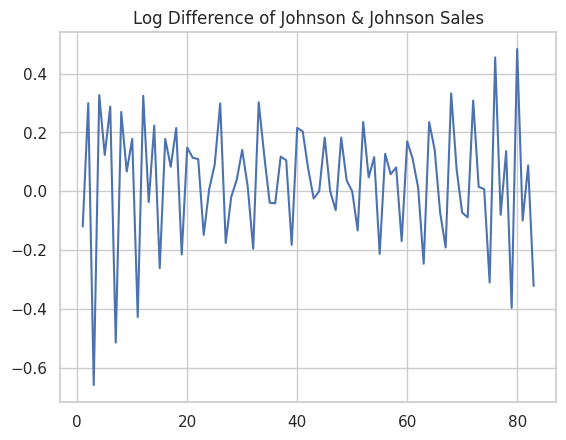

In [ ]:
plt.plot(jj_data['data_tr_1'])
plt.title("Log Difference of Johnson & Johnson Sales")
plt.show()

In [ ]:
ad_fuller_result = adfuller(jj_data['data_tr_1'][1:])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.317043945811837
p-value: 0.00041497314044406584


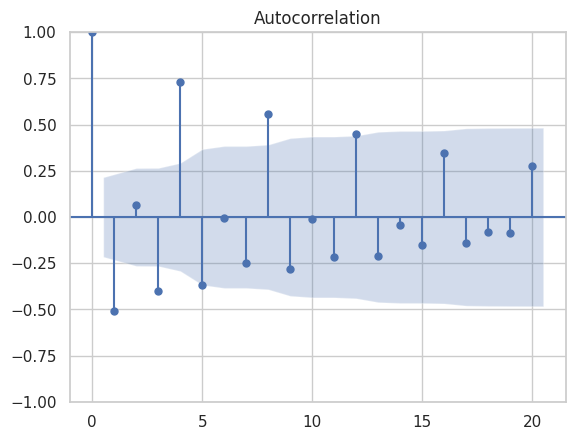

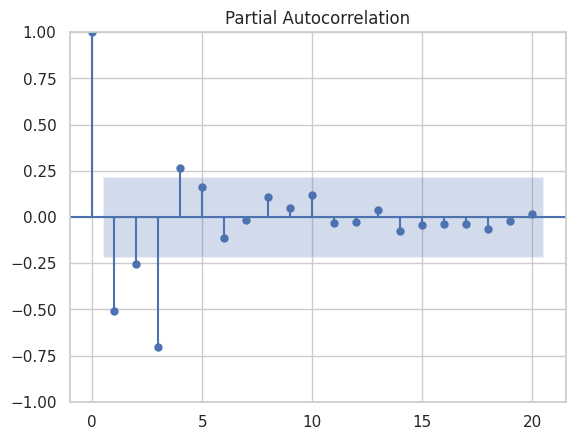

In [ ]:
plot_acf(jj_data['data_tr_1'][1:]);
plot_pacf(jj_data['data_tr_1'][1:]);
plt.show()

In [ ]:
# take the log()
amzn_data['data_log'] = np.log(amzn_data['Close'])
#take the first difference
amzn_data['data_tr_1'] = amzn_data['data_log'].diff()
amzn_data.head(10)

,Open,High,Low,Close,Adj Close,Volume,data_log,data_tr_1
Date,,,,,,,,
2018-02-20,72.324501,74.438499,72.324501,73.417503,73.417503,129984000,4.296162,NaN
2018-02-21,74.250000,75.174500,73.945999,74.146004,74.146004,126088000,4.306036,0.009874
2018-02-22,74.767998,75.126999,73.788002,74.266998,74.266998,97162000,4.307667,0.001631
2018-02-23,74.766998,75.000000,74.324997,75.000000,75.000000,88362000,4.317488,0.009821
2018-02-26,75.459999,76.141998,75.349998,76.097504,76.097504,99100000,4.332015,0.014527
2018-02-27,76.224998,76.338997,75.360497,75.598999,75.598999,96176000,4.325443,-0.006572
2018-02-28,75.975502,76.434998,75.599998,75.622498,75.622498,90300000,4.325754,0.000311
2018-03-01,75.680000,75.924500,73.250000,74.672501,74.672501,136704000,4.313112,-0.012642
2018-03-02,73.455002,75.052498,72.750504,75.012497,75.012497,131752000,4.317655,0.004543


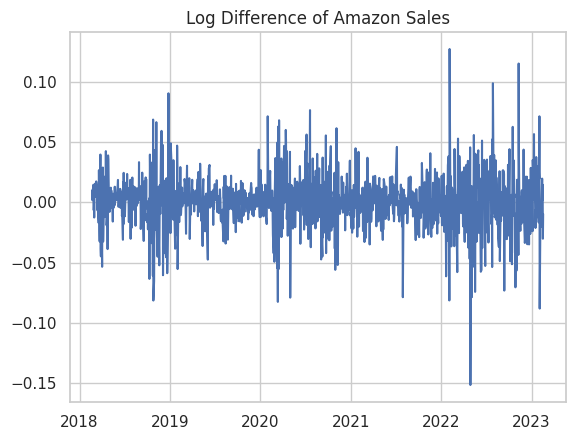

In [ ]:
plt.plot(amzn_data['data_tr_1'])
plt.title("Log Difference of Amazon Sales")
plt.show()

In [ ]:
ad_fuller_result = adfuller(amzn_data['data_tr_1'][1:])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -36.639832812749425
p-value: 0.0


In [ ]:
model = ARIMA(jj_data['data'], order=(3,1,3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 -76.286
Date:                Thu, 10 Apr 2025   AIC                            166.572
Time:                        09:41:21   BIC                            183.504
Sample:                             0   HQIC                           173.374
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0311      0.036    -28.924      0.000      -1.101      -0.961
ar.L2         -1.0273      0.043    -23.892      0.000      -1.112      -0.943
ar.L3         -0.9768      0.030    -32.190      0.0

In [ ]:
def optimize_ARIMA(endog, order_list):

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = ARIMA(endog, order=order)
            model_fit = model.fit()
        except:
            continue

        aic = model_fit.aic
        results.append([order, model_fit.aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
ps = range(0, 8, 1)
d = 0
qs = range(0, 8, 1)

# Create a list with combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)

# print out the first few rows
order_list[:10]


[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

In [ ]:
result_df = optimize_ARIMA(jj_data['data'], order_list)
result_df

<ipython-input-26-f7ea40a64ca7>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWar

,"(p, d, q)",AIC
0,"(6, 1, 3)",115.297318
1,"(4, 1, 6)",115.859233
2,"(7, 1, 1)",116.050450
3,"(5, 1, 3)",116.536224
4,"(5, 1, 4)",117.242599
...,...,...
59,"(0, 1, 1)",265.481216
60,"(0, 1, 3)",265.497398
61,"(1, 1, 0)",266.632563
62,"(2, 1, 0)",267.751437


In [ ]:
# p,d,q ARIMA Model
best_model = ARIMA(jj_data['data'], order=(6,1,3))
best_model_fit = best_model.fit()
#summary of the model
print(best_model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(6, 1, 3)   Log Likelihood                 -47.649
Date:                Thu, 10 Apr 2025   AIC                            115.297
Time:                        09:41:46   BIC                            139.486
Sample:                             0   HQIC                           125.015
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4733      0.127    -11.640      0.000      -1.721      -1.225
ar.L2         -0.7728      0.148     -5.235      0.000      -1.062      -0.484
ar.L3          0.0382      0.063      0.610      0.5

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


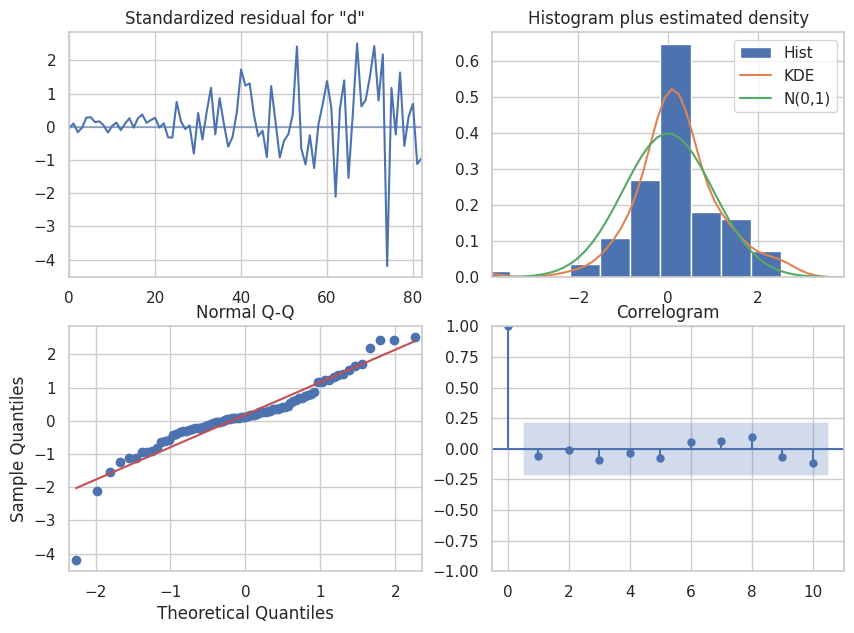

In [ ]:
best_model_fit.plot_diagnostics(figsize=(10,7))
plt.show()

In [ ]:
#get prediction start and end dates
test_data = jj_data['data']

pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

#get the predictions and residuals
predictions = best_model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

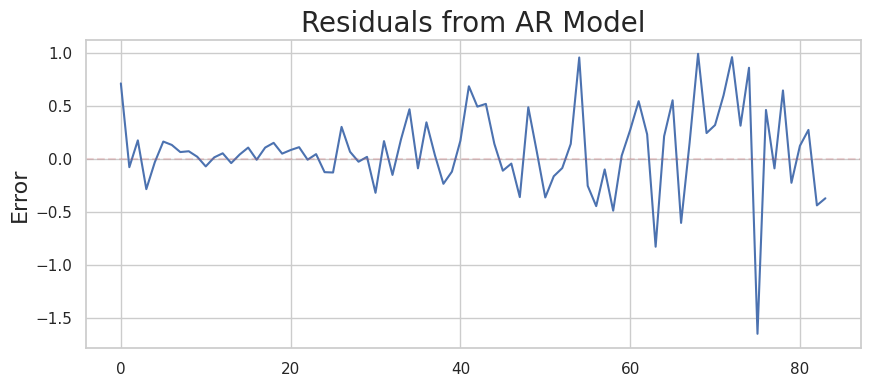

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

In [ ]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.3999081195935732


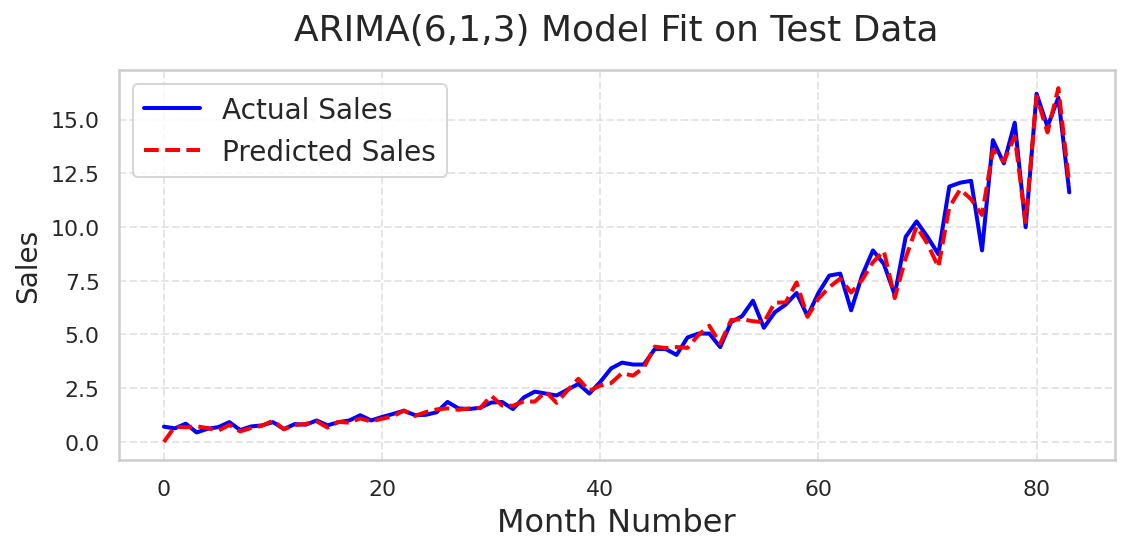

In [ ]:
# Plot the model prediction against the data

sns.set(style="whitegrid")
plt.figure(figsize=(8, 4), dpi=144)
plt.plot(test_data, label='Actual Sales', color='blue', linewidth=2)
plt.plot(predictions, label='Predicted Sales', color='red', linestyle='--', linewidth=2)
plt.title('ARIMA(6,1,3) Model Fit on Test Data', fontsize=18, pad=15)
plt.xlabel('Month Number', fontsize=16)
plt.ylabel('Sales', fontsize=14)
plt.legend(fontsize=14, loc='best', frameon=True)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    forecast = np.asarray(forecast)
    actual = np.asarray(actual)

    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))
    me = np.mean(forecast - actual)
    mae = np.mean(np.abs(forecast - actual))
    mpe = np.mean((forecast - actual) / actual)
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))
    corr = np.corrcoef(forecast, actual)[0, 1]

    mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins / maxs)

    return {
        'mape': mape, 'me': me, 'mae': mae,
        'mpe': mpe, 'rmse': rmse, 'corr': corr, 'minmax': minmax
    }

In [ ]:
forecast_accuracy(predictions, test_data)

{'mape': np.float64(0.08945519428653988),
 'me': np.float64(-0.07906178477112123),
 'mae': np.float64(0.2789680779228482),
 'mpe': np.float64(-0.027613316081548874),
 'rmse': np.float64(0.3999081195935732),
 'corr': np.float64(0.9958097298551797),
 'minmax': np.float64(0.08437238270774561)}

In [ ]:
n_forecast = 24 #24 months
predict = best_model_fit.get_prediction(end=model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

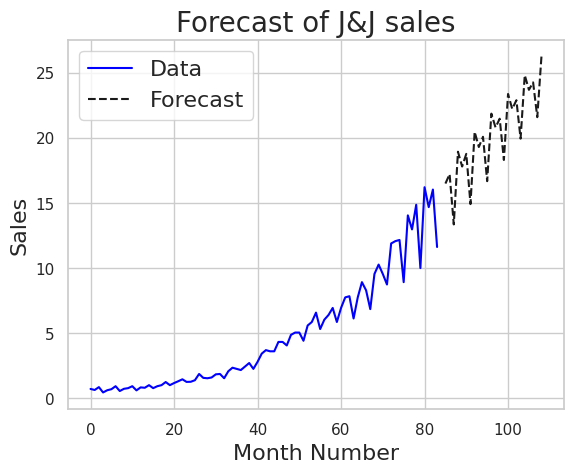

In [ ]:
# plot
fig, ax = plt.subplots()
ax.plot(jj_data['data'], 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--') #plots forecast
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Month Number', fontsize=16)
plt.title('Forecast of J&J sales', fontsize=20)
plt.legend(('Data', 'Forecast'), fontsize=16)
plt.show()

In [ ]:
# make the predictions for 24 steps ahead
predictions_int = best_model_fit.get_forecast(steps=26)
predictions_int.predicted_mean

,predicted_mean
84,17.336626
85,16.481965
86,17.203514
87,13.344421
88,18.924689
89,17.790273
90,18.762096
91,14.903689
92,20.454214
93,19.287892


In [ ]:
conf_df = pd.concat([predictions_int.predicted_mean, predictions_int.conf_int()], axis = 1)
conf_df.head()
conf_df = conf_df.rename(columns={'predicted_mean': 'Predictions', 'lower data': 'Lower CI', 'upper data': 'Upper CI'})
conf_df.head()

,Predictions,Lower CI,Upper CI
84,17.336626,16.565851,18.107401
85,16.481965,15.687898,17.276032
86,17.203514,16.341313,18.065716
87,13.344421,12.481034,14.207809
88,18.924689,17.509056,20.340322


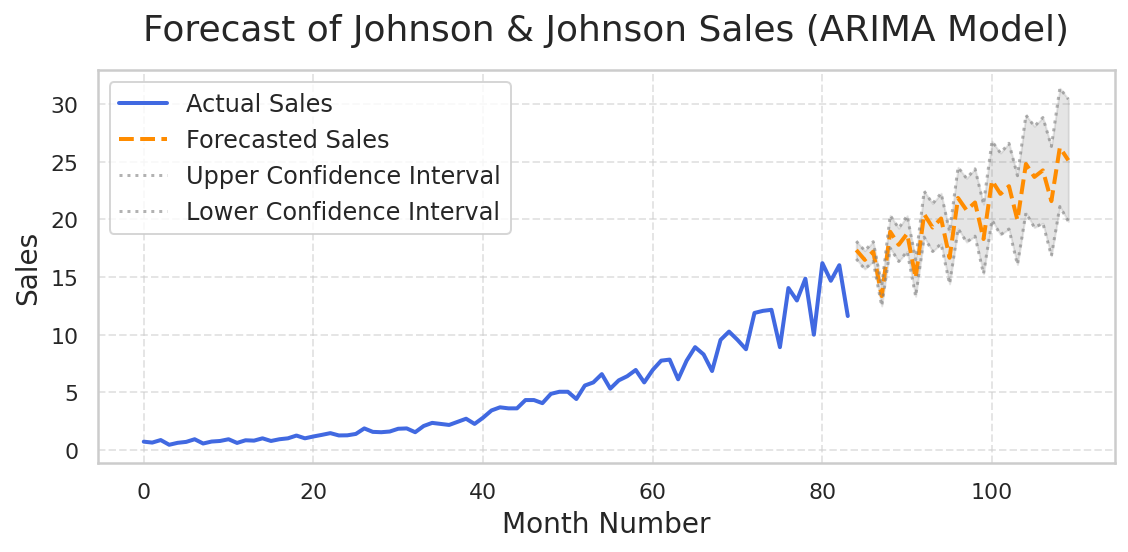

In [ ]:
#Forecast J&J sales
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 4), dpi=144)
ax.plot(jj_data['data'], label='Actual Sales', color='royalblue', linewidth=2)
conf_df['Predictions'].plot(ax=ax, color='darkorange', linestyle='--', linewidth=2, label='Forecasted Sales')
conf_df['Upper CI'].plot(ax=ax, color='grey', linestyle=':', alpha=0.6, label='Upper Confidence Interval')
conf_df['Lower CI'].plot(ax=ax, color='grey', linestyle=':', alpha=0.6, label='Lower Confidence Interval')
ax.fill_between(conf_df.index, conf_df['Lower CI'], conf_df['Upper CI'], color='grey', alpha=0.2)
ax.set_title('Forecast of Johnson & Johnson Sales (ARIMA Model)', fontsize=18, pad=15)
ax.set_ylabel('Sales', fontsize=14)
ax.set_xlabel('Month Number', fontsize=14)
ax.legend(loc='upper left', fontsize=12, frameon=True)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**ARIMA - Amazon Data**

In [ ]:
amzn_model = ARIMA(amzn_data['Close'], order=(3,1,3))
amzn_model_fit = amzn_model.fit()
print(amzn_model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1259
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -3055.652
Date:                Thu, 10 Apr 2025   AIC                           6125.305
Time:                        09:42:01   BIC                           6161.266
Sample:                             0   HQIC                          6138.820
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7321      0.062    -11.836      0.000      -0.853      -0.611
ar.L2          0.6699      0.102      6.538      0.000       0.469       0.871
ar.L3          0.9210      0.060     15.446      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# call opitimize_ARIMA
amzn_result_df = optimize_ARIMA(amzn_data['Close'], order_list)
amzn_result_df

<ipython-input-26-f7ea40a64ca7>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,"(p, d, q)",AIC
0,"(2, 1, 2)",6122.315476
1,"(3, 1, 2)",6124.039832
2,"(2, 1, 3)",6124.044468
3,"(3, 1, 3)",6125.304890
4,"(4, 1, 2)",6125.951759
...,...,...
59,"(0, 1, 7)",6138.374108
60,"(7, 1, 0)",6138.584491
61,"(4, 1, 7)",6138.645273
62,"(7, 1, 7)",6139.511615


In [ ]:
# p,d,q ARIMA Model
amzn_best_model = ARIMA(amzn_data['Close'], order=(2,1,2))
amzn_best_model_fit = amzn_best_model.fit()
#summary of the model
print(amzn_best_model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1259
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3056.158
Date:                Thu, 10 Apr 2025   AIC                           6122.315
Time:                        09:43:23   BIC                           6148.002
Sample:                             0   HQIC                          6131.969
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6946      0.015   -111.813      0.000      -1.724      -1.665
ar.L2         -0.9604      0.015    -64.728      0.000      -0.989      -0.931
ma.L1          1.6972      0.011    152.237      0.0

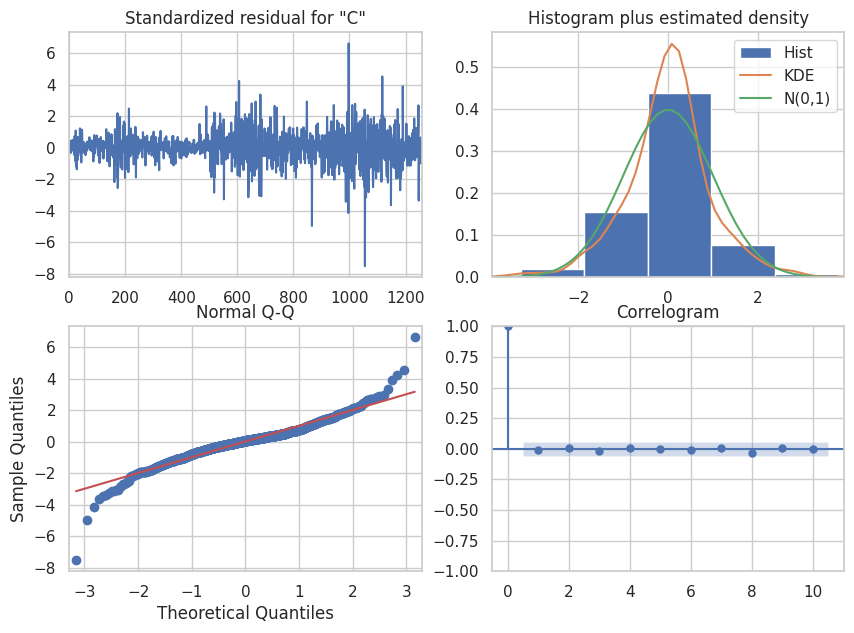

In [ ]:
amzn_best_model_fit.plot_diagnostics(figsize=(10,7))
plt.show()

In [ ]:
#get prediction start and end dates
amzn_test_data = amzn_data['Close']
pred_start_date = amzn_test_data.index[0]
pred_end_date = amzn_test_data.index[-1]
#get the predictions and residuals
amzn_predictions = amzn_best_model_fit.predict(start=pred_start_date, end=pred_end_date)
amzn_residuals = amzn_test_data - amzn_predictions

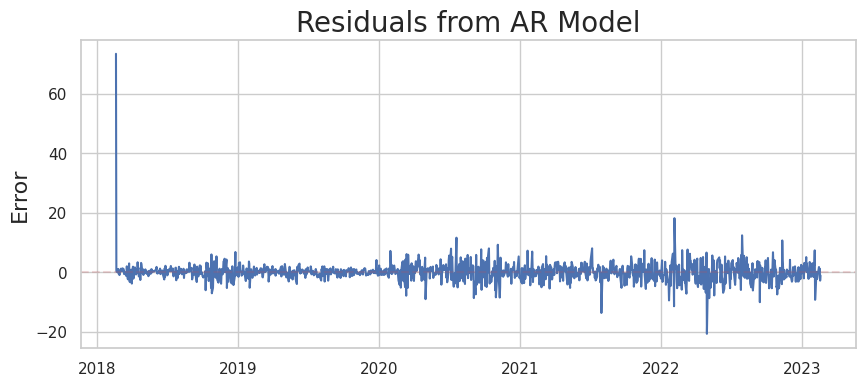

In [ ]:
 #plot residuals
plt.figure(figsize=(10,4))
plt.plot(amzn_residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0.5, 0, 'Month Number')

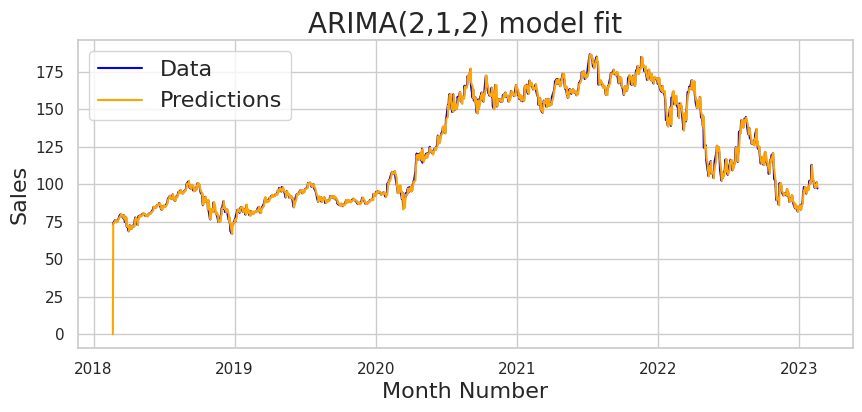

In [ ]:
# Plot the model prediction against the data

plt.figure(figsize=(10,4))
plt.plot(amzn_test_data,color='blue')
plt.plot(amzn_predictions,color='orange')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title('ARIMA(2,1,2) model fit', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Month Number', fontsize=16)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-50-356a306093ff>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_idx + pd.offsets.MonthEnd(1), periods=n_forecast, freq='M')
<ipython-input-50-356a306093ff>:24: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(forecast_index, predicted_mean[-n_forecast:], linestyle='--', color='crimson', linewidth=2, label='Forecast')

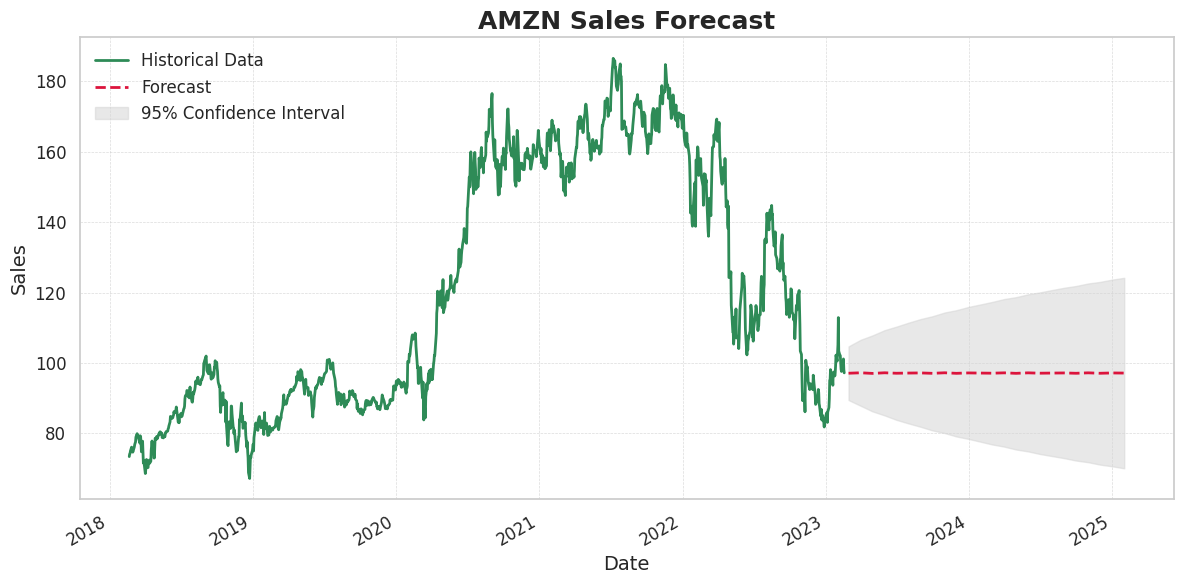

In [ ]:
# Forecast parameters
n_forecast = 24  # 24 months
amzn_predict = amzn_best_model_fit.get_prediction(end=amzn_model.nobs + n_forecast)

# Extract predicted values and confidence intervals
predicted_mean = amzn_predict.predicted_mean
forecast_conf_int = amzn_predict.conf_int()

# Generate forecast index
last_idx = amzn_data.index[-1]
forecast_index = pd.date_range(start=last_idx + pd.offsets.MonthEnd(1), periods=n_forecast, freq='M')

# Extract bounds
lower_bound = forecast_conf_int.iloc[:, 0]
upper_bound = forecast_conf_int.iloc[:, 1]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Historical data
amzn_data['Close'].plot(ax=ax, label='Historical Data', color='seagreen', linewidth=2)

# Forecast line
ax.plot(forecast_index, predicted_mean[-n_forecast:], linestyle='--', color='crimson', linewidth=2, label='Forecast')

# Confidence interval
ax.fill_between(forecast_index,
                lower_bound[-n_forecast:], upper_bound[-n_forecast:],
                color='lightgrey', alpha=0.5, label='95% Confidence Interval')

# Labels and title
ax.set_title('AMZN Sales Forecast', fontsize=18, fontweight='bold')
ax.set_ylabel('Sales', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# Grid and legend
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend(loc='upper left', fontsize=12, frameon=False)

plt.tight_layout()
plt.show()

**LSTM Based Forecasting**

In [ ]:
def timeseries_transform_data(data, lag=1):
  """ Function to transform data to be supervised learning.
  Returns the transformed dataframe.
  Args:
    data: A list of data to be transformed.
    lag: Number of lag needed.
    """

  df = pd.DataFrame(data)
  columns = [df.shift(i) for i in range(1, lag+1)]
  columns.append(df)
  df = pd.concat(columns, axis=1)
  df.fillna(0, inplace=True)
  return df

In [ ]:
def scale(train, test):
  # fit scaler
  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaler = scaler.fit(train)

  # transform train
  train = train.reshape(train.shape[0], train.shape[1])
  train_scaled = scaler.transform(train)

  # transform test
  test = test.reshape(test.shape[0], test.shape[1])
  test_scaled = scaler.transform(test)
  return scaler, train_scaled, test_scaled

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

def fit_lstm(train, batch_size, nb_epoch, neurons):
    """ Function to fit an LSTM network to training data.
    Returns the fit model.
    Args:
    train: training data.
    batch_size: batch size.
    nb_epoch: number of epochs to train.
    neurons: number of neurons.
    """
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])  # [samples, time steps, features]

    model = Sequential()
    model.add(LSTM(neurons, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)

    return model

In [ ]:
def forecast_lstm(model, batch_size, X):
  """ Function to make a one-step forecast.
  Returns the forecast.
  Args:
    model: Model to forecast the data.
    batch_size: Batch size used.
    X: Data to be forecasted.
  """

  X = X.reshape(1, 1, len(X))
  yhat = model.predict(X, batch_size=batch_size)
  return yhat[0,0]

In [ ]:
def invert_scale(scaler, X, value):
  new_row = [x for x in X] + [value]
  array = np.array(new_row)
  array = array.reshape(1, len(array))
  inverted = scaler.inverse_transform(array)
  return inverted[0, -1]

def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

In [ ]:
#Load data
jj_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/jj.csv')
jj_df['date']= pd.to_datetime(jj_df['date'])
jj_df.set_index('date', inplace=True)

In [ ]:
#log transformation
log_jj = np.log(jj_df['data'])
diff_log_jj = log_jj.diff().dropna()

In [ ]:
supervised = timeseries_transform_data(data=diff_log_jj, lag=1)
supervised_values = supervised.values

In [ ]:
# split data into train and test sets
train, test = supervised_values[0:-16], supervised_values[-16:]
scaler, train_scaled, test_scaled = scale(train, test)

In [ ]:
repeats = 30
error_scores = list()
pred_list = list()

for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(train=train_scaled, batch_size=1, nb_epoch=50,
                          neurons=4)

    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)

    # validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler=scaler, X=X, value=yhat)
        # invert differencing
        yhat = inverse_difference(history=log_jj, yhat=yhat,
                                  interval=len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)

    rmse = np.sqrt(mean_squared_error(log_jj[-16:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    pred_list.append(predictions)
    error_scores.append(rmse)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1) Test RMSE: 0.205


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2) Test RMSE: 0.207


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3) Test RMSE: 0.203


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4) Test RMSE: 0.202


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

5) Test RMSE: 0.217


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6) Test RMSE: 0.204


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7) Test RMSE: 0.220


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
8) Test RMSE: 0.204


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
9) Test RMSE: 0.204


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
10) Test RMSE: 0.206


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
11) Test RMSE: 0.203


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
12) Test RMSE: 0.202


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13) Test RMSE: 0.206


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
14) Test RMSE: 0.207


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
15) Test RMSE: 0.205


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
16) Test RMSE: 0.205


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do no

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
17) Test RMSE: 0.215


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
18) Test RMSE: 0.204


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
19) Test RMSE: 0.204


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do no

20) Test RMSE: 0.222
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
21) Test RMSE: 0.205


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
22) Test RMSE: 0.204


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
23) Test RMSE: 0.213


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do no

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
24) Test RMSE: 0.204


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
25) Test RMSE: 0.201


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
26) Test RMSE: 0.203


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
27) Test RMSE: 0.218


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do no

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
28) Test RMSE: 0.205


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as posi

29) Test RMSE: 0.208
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
30) Test RMSE: 0.200


<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]
<ipython-input-104-fd7113ba23f9>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return yhat + history[-interval]


In [ ]:
results = pd.DataFrame()
results['RMSE'] = error_scores
print(results.describe(), '\n')

            RMSE
count  30.000000
mean    0.206811
std     0.005855
min     0.200167
25%     0.203625
50%     0.204609
75%     0.206850
max     0.221979 



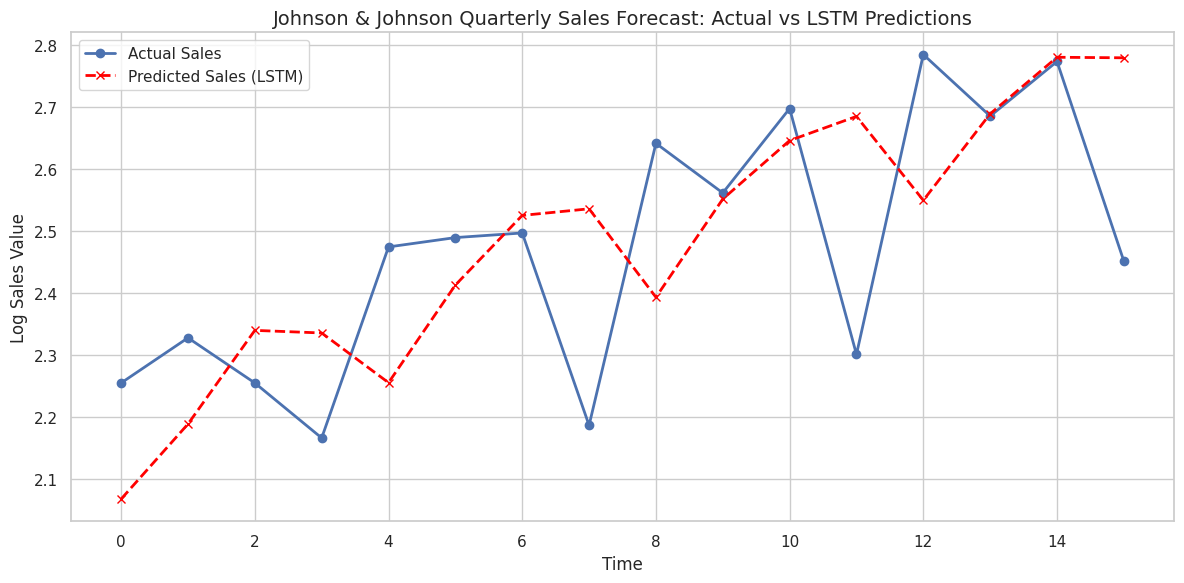

In [ ]:
# plot actual and predicted data
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
plt.plot(log_jj[-16:].values, label='Actual Sales', linewidth=2, marker='o')
plt.plot(pred_list[np.argmin(results)], linestyle='--', color='red',
         label='Predicted Sales (LSTM)', linewidth=2, marker='x')
plt.title('Johnson & Johnson Quarterly Sales Forecast: Actual vs LSTM Predictions', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Log Sales Value', fontsize=12)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

### LSTM - Amazon Data

In [ ]:
# read in data file
amzn_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AMZN.csv')
amzn_df['Date']= pd.to_datetime(amzn_df['Date'])
amzn_df.set_index('Date', inplace=True)

In [ ]:
# find best lambda
boxcox_amzn, lam = boxcox(amzn_df['Close'])
print(f'Lambda = {lam}')
boxcox_amzn = pd.DataFrame(boxcox_amzn)
diff_boxcox_amzn = boxcox_amzn.diff().dropna()

Lambda = -0.3699998709183637


In [ ]:
# transform data
supervised = timeseries_transform_data(data=diff_boxcox_amzn, lag=1)
supervised_values = supervised.values

In [ ]:
# split data
train, test = supervised_values[0:-250], supervised_values[-250:]
# scale the data to -1 and 1
scaler, train_scaled, test_scaled = scale(train, test)

In [ ]:
# fit the model
lstm_model = fit_lstm(train=train_scaled, batch_size=1, nb_epoch=50,
                      neurons=4)

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# validation on the test data
predictions = list()
for i in range(len(test_scaled)):
  X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
  yhat = forecast_lstm(lstm_model, 1, X)
  yhat = invert_scale(scaler=scaler, X=X, value=yhat)
  yhat = inverse_difference(history=boxcox_amzn.values, yhat=yhat,
                            interval=len(test_scaled)+1-i)
  # store forecast
  predictions.append(yhat)

# report performance
rmse = np.sqrt(mean_squared_error(boxcox_amzn[-250:], predictions))
print('Test RMSE =', np.round(rmse, 3))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1008/1008 ━━━━━━━━━━━━━━━━━━━━ 1s 837us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━

In [ ]:
rmse

np.float64(0.005388030292525304)

<ipython-input-124-9f9c2ae1733b>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(predictions, 'r--', label='Prediction', color='red', linewidth=2)


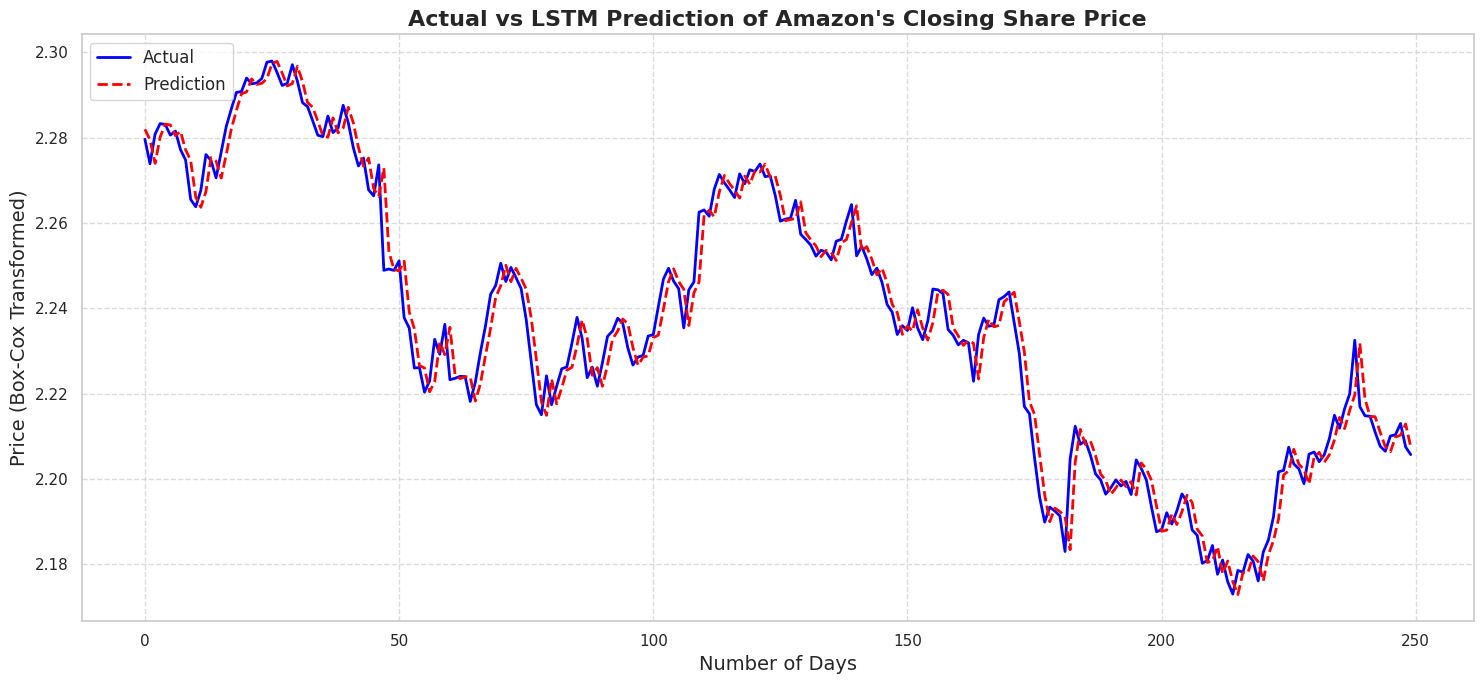

In [ ]:
# Plot Amazon Closing Price
plt.figure(figsize=(15,7))
plt.plot(boxcox_amzn[-250:].values, label='Actual', color='blue', linewidth=2)
plt.plot(predictions, 'r--', label='Prediction', color='red', linewidth=2)
plt.title("Actual vs LSTM Prediction of Amazon's Closing Share Price", fontsize=16, fontweight='bold')
plt.xlabel('Number of Days', fontsize=14)
plt.ylabel('Price (Box-Cox Transformed)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()